In [5]:
import re, pickle
from datetime import datetime, timedelta
import GPy
import numpy as np
import pandas as pd
import matplotlib.cm as cm
from matplotlib import pyplot as plt
from IPython.display import display
from mapsplotlib import mapsplot as mplt

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib options
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

In [6]:
# matplotlib options (for some reason, in many computers, needs to be run twice to take effect...)
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

# Load data

In [7]:
df = pd.read_excel("DTU - data til case_LTMZones2.xlsx")
df.head()

,TurID,BilID,PersonID,Latitude (Start),Longitude (Start),Latitude (Slut),Longitude (Slut),Reservationstidspunkt,Start tidspunkt,Slut tidspunkt,Alder,Køn,Batteristatus (start),Batteristatus (slut),Km kørt,FromZoneID,ToZoneID
0,1,WBY1Z21040V307905,32614,55.6703,12.5861,55.653,12.5447,2017-08-16 14:40:29,2017-08-16 14:34:29,2017-08-16 14:52:55,32,M,94,91,5,103142,102851
1,2,WBY1Z21040V308214,44363,55.687,12.586,55.7267,12.5539,2017-08-16 14:42:00,2017-08-16 14:38:00,2017-08-16 15:05:22,25,M,48,42,7,102212,157231
2,3,WBY1Z21070V307929,38610,55.6924,12.5831,55.7757,12.514,2017-07-31 07:28:38,2017-07-31 07:21:38,2017-08-01 12:49:44,21,M,0,0,19,102213,173051
3,4,WBY1Z21040V307869,37425,55.6303,12.6489,55.7069,12.5871,2017-07-31 20:31:07,2017-07-31 20:31:07,2017-08-01 09:13:25,30,M,0,0,18,185203,102341
4,5,WBY1Z21030V307877,24168,55.6936,12.5382,55.6775,12.4892,2017-07-31 20:48:30,2017-07-31 20:44:30,2017-08-01 08:52:43,28,M,0,0,5,102454,102771


In [8]:
# convert dates to datetime format
df["Reservationstidspunkt"] = pd.to_datetime(df["Reservationstidspunkt"], format="%Y-%m-%d %H:%M:%S")
df["Start tidspunkt"] = pd.to_datetime(df["Start tidspunkt"], format="%Y-%m-%d %H:%M:%S")
df["Slut tidspunkt"] = pd.to_datetime(df["Slut tidspunkt"], format="%Y-%m-%d %H:%M:%S")
df["date"] = df["Start tidspunkt"].dt.date

# Basic descriptive statistics

In [9]:
print("Total transactions:", len(df))
print("Total number of cars:", len(np.unique(df["BilID"])))
print("Number of unique customers:", len(np.unique(df["PersonID"])))
print("Period start:", df["date"].min())
print("Period end:", df["date"].max())

Total transactions: 366420
Total number of cars: 347
Number of unique customers: 25380
Period start: 2017-07-31
Period end: 2018-05-08


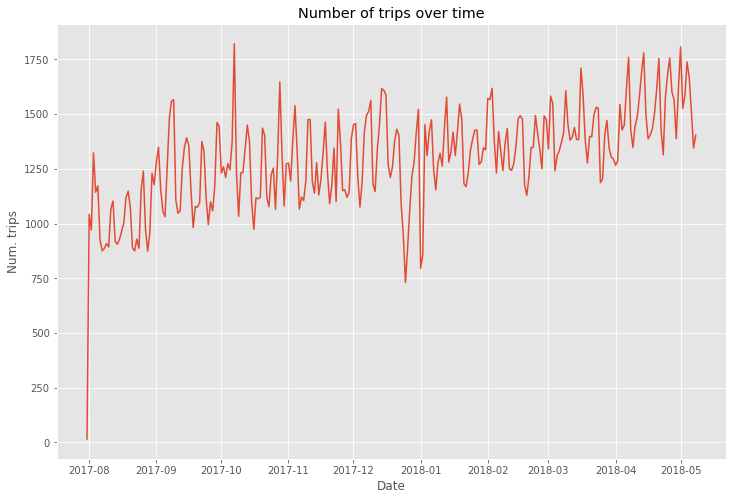

In [10]:
grouped = df.groupby("date")["TurID"].count()
plt.plot(grouped.index, grouped.values)
plt.xlabel("Date")
plt.ylabel("Num. trips")
plt.title("Number of trips over time")
plt.show()

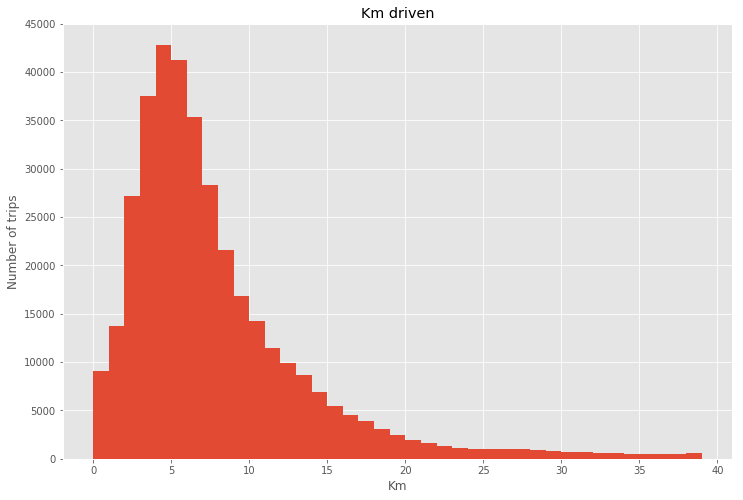

In [11]:
plt.hist(df["Km kørt"], bins=range(40))
plt.title("Km driven")
plt.xlabel("Km")
plt.ylabel("Number of trips")
plt.show()

# Process data and generate demand and supply

In [12]:
# sort trips by start time
df_sorted = df.sort_values("Start tidspunkt")

In [13]:
zone_ids = np.unique((df["FromZoneID"] / 10).astype(np.int)).tolist()
for z_id in np.unique((df["ToZoneID"] / 10).astype(np.int)).tolist():
    if z_id not in zone_ids:
        zone_ids.append(z_id)
vehicle_ids = np.unique(df["BilID"])

# keep track of all vehicles at every time step
vehicle_pos = {v_id:None for v_id in vehicle_ids}
vehicle_zone = {v_id:None for v_id in vehicle_ids}
output_dir = "/mnt/sdb1/data_fmpr/DriveNow"
n = 0
start_date = datetime(2017, 8, 5) # ignore data before this datetime
current_time = 0
current_date = start_date.strftime("%Y-%m-%d %H:00")
total_moves = 0
total_phanton_moves = 0
invalid_trips = 0
errors = 0
dates = {}
demand = {}
supply = {}
demand_temp = {z_id:0 for z_id in zone_ids}
for ix, row in df_sorted.iterrows():
    n += 1
    if not n % 10000:
        print("%d of %d rows processed! %d of %d trips were phantom; %d trips were invalid; %d errors found so far" \
              % (n, len(df), total_phanton_moves, total_moves, invalid_trips, errors))
    
    # ignore invalid rows
    if row["BilID"] == '-':
        invalid_trips += 1
        continue
    try:
        start_lat = float(row["Latitude (Start)"])
        start_lng = float(row["Longitude (Start)"])
        end_lat = float(row["Latitude (Slut)"])
        end_lng = float(row["Longitude (Slut)"])
    except:
        invalid_trips += 1
        continue
    
    # skip the first days so that we can figure out the positions of all cars
    if row["Start tidspunkt"] < start_date:
        # save vehicle position for tracking
        vehicle_pos[row["BilID"]] = (end_lat, end_lng)
        continue
    
    # get current time bin (by hour)
    time = int((row["Start tidspunkt"] - start_date).total_seconds() / 60 / 60)
    
    if time != current_time: # if time bin (hour) has changed
        # compute supply
        supply_temp = {z_id:0 for z_id in zone_ids}
        for v_id in vehicle_zone:
            if vehicle_zone[v_id] != None:
                supply_temp[vehicle_zone[v_id]] += 1
                
        # check that demand <= supply
        for z_id in zone_ids:
            if demand_temp[z_id] > supply_temp[z_id]:
                errors += 1
                #print("error:", z_id, demand_temp[z_id], supply_temp[z_id])
        
        # save supply and demand for previous time bin (the current observation already belongs to a new one)
        dates[current_time] = current_date
        demand[current_time] = demand_temp
        supply[current_time] = supply_temp
        
        # reset variables
        demand_temp = {z_id:0 for z_id in zone_ids}
        current_time = time
        current_date = row["Start tidspunkt"].strftime("%Y-%m-%d %H:00")
        
    # get origin and destination zones
    origin_zone = int(int(row["FromZoneID"]) / 10)
    destination_zone = int(int(row["ToZoneID"]) / 10)
        
    # check if there was a phanton move
    if vehicle_pos[row["BilID"]] != None \
                    and start_lat != vehicle_pos[row["BilID"]][0] \
                    and start_lng != vehicle_pos[row["BilID"]][1]:
        total_phanton_moves += 1
    total_moves += 1
    
    # update vehicle position and zone in tracking
    vehicle_pos[row["BilID"]] = (end_lat, end_lng)
    vehicle_zone[row["BilID"]] = destination_zone
    
    # update demand for corresponding zone
    demand_temp[origin_zone] += 1

print("\nDone!")
print("%d of %d trips were phantom trips" % (total_phanton_moves, total_moves))
print("%d of %d trips were invalid trips" % (invalid_trips, total_moves))
print("%d errors found" % (errors,))

10000 of 366420 rows processed! 665 of 5505 trips were phantom; 0 trips were invalid; 615 errors found so far
20000 of 366420 rows processed! 1820 of 15505 trips were phantom; 0 trips were invalid; 1411 errors found so far
30000 of 366420 rows processed! 2994 of 25505 trips were phantom; 0 trips were invalid; 2139 errors found so far
40000 of 366420 rows processed! 4102 of 35505 trips were phantom; 0 trips were invalid; 2839 errors found so far
50000 of 366420 rows processed! 5257 of 45505 trips were phantom; 0 trips were invalid; 3629 errors found so far
60000 of 366420 rows processed! 6388 of 55505 trips were phantom; 0 trips were invalid; 4372 errors found so far
70000 of 366420 rows processed! 7450 of 65505 trips were phantom; 0 trips were invalid; 5170 errors found so far
80000 of 366420 rows processed! 8573 of 75505 trips were phantom; 0 trips were invalid; 5906 errors found so far
90000 of 366420 rows processed! 9524 of 85505 trips were phantom; 0 trips were invalid; 6700 errors

In [17]:
# check fraction of cases in which demand is greater than (or equal to) the supply
total_cases = 0
boundary_cases = 0
problem_cases = 0
for t in demand:
    for z_id in zone_ids:
        if demand[t][z_id] == supply[t][z_id]:
            boundary_cases += 1
        elif demand[t][z_id] > supply[t][z_id]:
            problem_cases += 1
        total_cases += 1

print("Total cases:", total_cases)
print("Total boundary cases: %d (%.1f perc.)" % (boundary_cases, 100.0*boundary_cases/total_cases))
print("Total problematic cases: %d (%.1f perc.)" % (problem_cases, 100.0*problem_cases/total_cases))

Total cases: 1187665
Total boundary cases: 643249 (54.2 perc.)
Total problematic cases: 27962 (2.4 perc.)


# Visualize data for an example zone

Fraction of boundary cases: 0.067
Fraction of problematic cases: 0.059


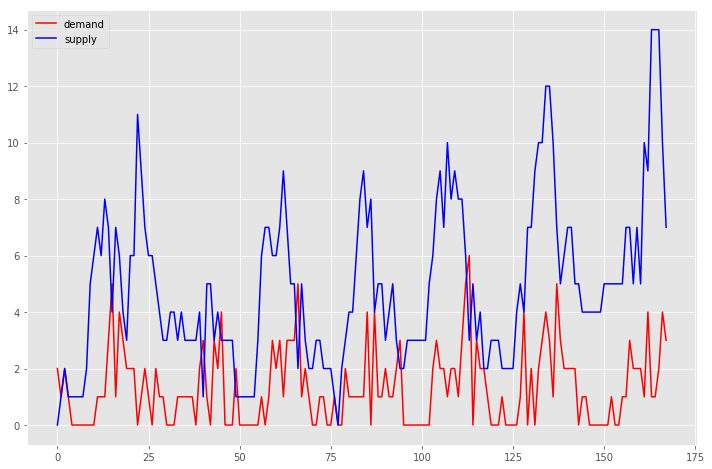

In [96]:
zone_id = 10222
demand_ts = [demand[t][zone_id] for t in demand]
supply_ts = [supply[t][zone_id] for t in demand]
print("Fraction of boundary cases: %.3f" % (np.sum(np.array(demand_ts) == np.array(supply_ts)) / len(demand_ts)),)
print("Fraction of problematic cases: %.3f" % (np.sum(np.array(demand_ts) > np.array(supply_ts)) / len(demand_ts)),)
plt.plot(demand_ts[:(24*7)], "r-")
plt.plot(supply_ts[:(24*7)], "b-")
plt.legend(["demand", "supply"], loc="upper left")
plt.show()

Fraction of boundary cases: 0.286
Fraction of problematic cases: 0.127


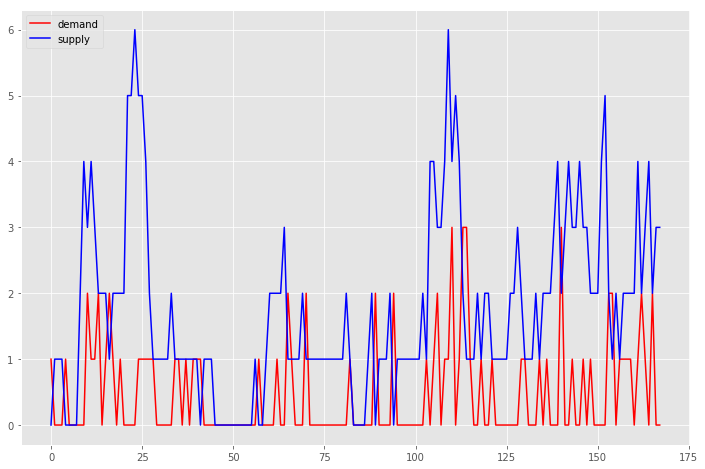

In [90]:
zone_id = 10212
demand_ts = [demand[t][zone_id] for t in demand]
supply_ts = [supply[t][zone_id] for t in demand]
print("Fraction of boundary cases: %.3f" % (np.sum(np.array(demand_ts) == np.array(supply_ts)) / len(demand_ts)),)
print("Fraction of problematic cases: %.3f" % (np.sum(np.array(demand_ts) > np.array(supply_ts)) / len(demand_ts)),)
plt.plot(demand_ts[:(24*7)], "r-")
plt.plot(supply_ts[:(24*7)], "b-")
plt.legend(["demand", "supply"], loc="upper left")
plt.show()

Fraction of boundary cases: 0.562
Fraction of problematic cases: 0.063


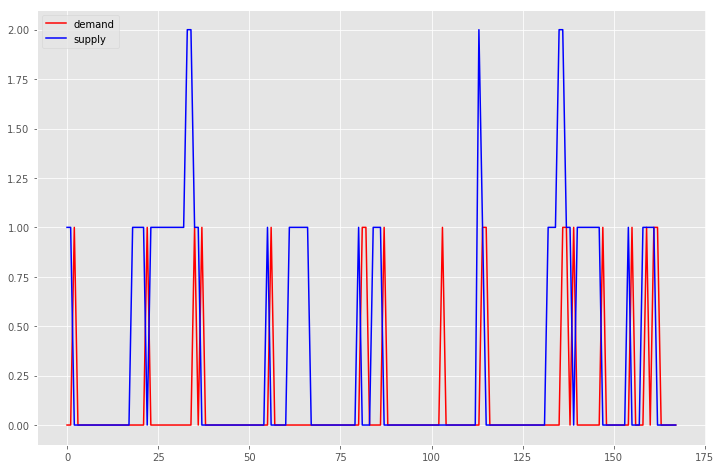

In [91]:
zone_id = 10211
demand_ts = [demand[t][zone_id] for t in demand]
supply_ts = [supply[t][zone_id] for t in demand]
print("Fraction of boundary cases: %.3f" % (np.sum(np.array(demand_ts) == np.array(supply_ts)) / len(demand_ts)),)
print("Fraction of problematic cases: %.3f" % (np.sum(np.array(demand_ts) > np.array(supply_ts)) / len(demand_ts)),)
plt.plot(demand_ts[:(24*7)], "r-")
plt.plot(supply_ts[:(24*7)], "b-")
plt.legend(["demand", "supply"], loc="upper left")
plt.show()

Fraction of boundary cases: 0.027
Fraction of problematic cases: 0.014


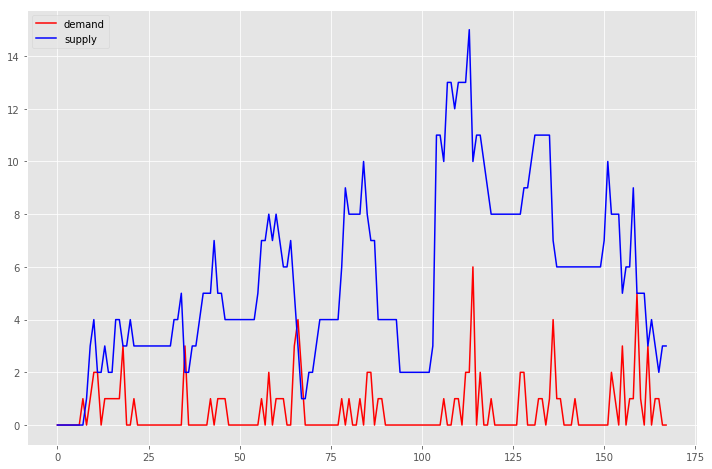

In [92]:
zone_id = 10233
demand_ts = [demand[t][zone_id] for t in demand]
supply_ts = [supply[t][zone_id] for t in demand]
print("Fraction of boundary cases: %.3f" % (np.sum(np.array(demand_ts) == np.array(supply_ts)) / len(demand_ts)),)
print("Fraction of problematic cases: %.3f" % (np.sum(np.array(demand_ts) > np.array(supply_ts)) / len(demand_ts)),)
plt.plot(demand_ts[:(24*7)], "r-")
plt.plot(supply_ts[:(24*7)], "b-")
plt.legend(["demand", "supply"], loc="upper left")
plt.show()

Fraction of boundary cases: 0.408
Fraction of problematic cases: 0.097


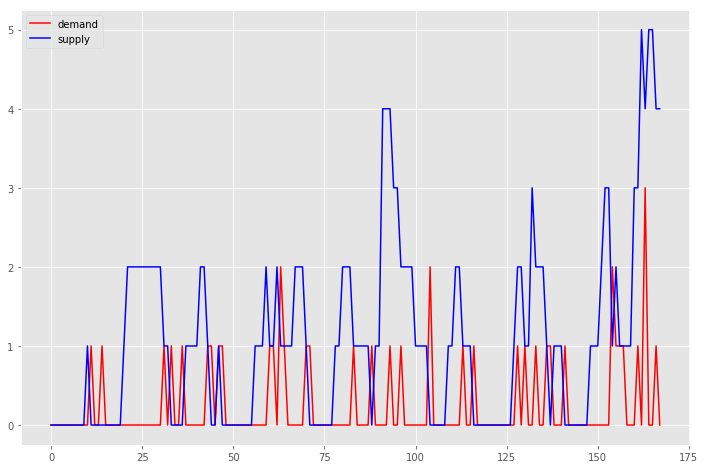

In [93]:
zone_id = 10223
demand_ts = [demand[t][zone_id] for t in demand]
supply_ts = [supply[t][zone_id] for t in demand]
print("Fraction of boundary cases: %.3f" % (np.sum(np.array(demand_ts) == np.array(supply_ts)) / len(demand_ts)),)
print("Fraction of problematic cases: %.3f" % (np.sum(np.array(demand_ts) > np.array(supply_ts)) / len(demand_ts)),)
plt.plot(demand_ts[:(24*7)], "r-")
plt.plot(supply_ts[:(24*7)], "b-")
plt.legend(["demand", "supply"], loc="upper left")
plt.show()